In [1]:
#https://glowingpython.blogspot.com/2014/02/terms-selection-with-chi-square.html
#https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1
# https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223
# https://realpython.com/sentiment-analysis-python/

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

cwd = os.getcwd()

# inicializácia mojich funkcií
sys.path.insert(1,cwd + '/insAInDev_Tools/')
import insAInDev_Processor as insAIProc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zoltanhalasz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zoltanhalasz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


addit elexacaftor generat cftr corrector tezacaftor plus ivacaftor improv cftr function clinic outcom phase studi peopl cystic fibrosi homozyg mutat like scienti
addit elexacaftor vx next gener cftr corrector tezacaftor plu ivacaftor improv f del cftr function clinic outcom phase studi peopl cystic fibrosi homozyg f del mutat id like scienti
addit elexacaftor vx next gener cftr corrector tezacaftor plu ivacaftor improv f del cftr function clinic outcom phase studi peopl cystic fibrosi homozyg f del mutat id like be scienti
dave watch forest burn hill mile hous hadbeen hastili pack marta insid tri roundup pet wonder continu wait marta appear pet hero


### Načítanie datasetu

In [2]:
# nastavenie vizualizácie full text length
pd.set_option('display.max_colwidth', -1)

# separátor stĺpcov sa používa tabulator (pre čiarku to je sep=',')
df = pd.read_csv(cwd + '/Datasets/ChiSquare_CFTR/CFTR_Dataset.txt',sep='\t', error_bad_lines=False,  encoding = "ISO-8859-1" )
# zobrazenie prvých 3 riadkov 
df.head(3)

<ipython-input-2-bfc8025ccd15>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,pubmedid,pmc,text,Review,chemical,mutation,Interaction
0,28592587,PMC5471438,The observation that linaclotide stimulated fluid secretion and CFTR trafficking into the brush border surface in the rat small intestine in vivo led us to investigate the mechanisms of linaclotide-mediated downstream signaling pathways involved in fluid secretion,Its inhibitory effect was more profound when tissues were stimulated with lower concentrations of linaclotide. Cyclic GMP-dependent kinase cGKII is expressed in C2BBe and T84 cells. The observation that linaclotide stimulated fluid secretion and CFTR trafficking into the brush border surface in the rat small intestine in vivo led us to investigate the mechanisms of linaclotide-mediated downstream signaling pathways involved in fluid secretion. Cyclic GMP-dependent kinase cGKII is expressed in C2BBe and T84 cells,linaclotide,cftr,1
1,21882224,NaN,We recently discovered that hyaluronan was exported from fibroblasts by MRP5 and from epithelial cells by cystic fibrosis (CF) transmembrane conductance regulator (CFTR) that was known as a chloride channel,We recently discovered that hyaluronan was exported from fibroblasts by MRP5 and from epithelial cells by cystic fibrosis (CF) transmembrane conductance regulator (CFTR) that was known as a chloride channel. Recovery of _ÓF508-CFTR function by analogs of hyaluronan disaccharide. We recently discovered that hyaluronan was exported from fibroblasts by MRP5 and from epithelial cells by cystic fibrosis (CF) transmembrane conductance regulator (CFTR) that was known as a chloride channel,chloride,cftr,2
2,19309154,PMC2832307,Clinical doses of amikacin provide more effective suppression of the human CFTR-G542X stop mutation than gentamicin in a transgenic CF mouse model,Five percent of normal cystic fibrosis transmembrane conductance regulator mRNA ameliorates the severity of pulmonary disease in cystic fibrosis. Clinical doses of amikacin provide more effective suppression of the human CFTR-G542X stop mutation than gentamicin in a transgenic CF mouse model. Clinical doses of amikacin provide more effective suppression of the human CFTR-G542X stop mutation than gentamicin in a transgenic CF mouse model,amikacin,cftr,1


### Príprava datasetu s konkrétnymi stĺpcami

In [3]:
col = ['Review', 'Interaction']
df = df[col]
df = df[pd.notnull(df['Review'])]
df['Interaction'] = df['Interaction']

#necessary for confusion matrix
df['category_id'] = df['Interaction'].factorize()[0]
category_id_df = df[['Interaction', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Interaction']].values)

df.head(3)

,Review,Interaction,category_id
0,Its inhibitory effect was more profound when tissues were stimulated with lower concentrations of linaclotide. Cyclic GMP-dependent kinase cGKII is expressed in C2BBe and T84 cells. The observation that linaclotide stimulated fluid secretion and CFTR trafficking into the brush border surface in the rat small intestine in vivo led us to investigate the mechanisms of linaclotide-mediated downstream signaling pathways involved in fluid secretion. Cyclic GMP-dependent kinase cGKII is expressed in C2BBe and T84 cells,1,0
1,We recently discovered that hyaluronan was exported from fibroblasts by MRP5 and from epithelial cells by cystic fibrosis (CF) transmembrane conductance regulator (CFTR) that was known as a chloride channel. Recovery of _ÓF508-CFTR function by analogs of hyaluronan disaccharide. We recently discovered that hyaluronan was exported from fibroblasts by MRP5 and from epithelial cells by cystic fibrosis (CF) transmembrane conductance regulator (CFTR) that was known as a chloride channel,2,1
2,Five percent of normal cystic fibrosis transmembrane conductance regulator mRNA ameliorates the severity of pulmonary disease in cystic fibrosis. Clinical doses of amikacin provide more effective suppression of the human CFTR-G542X stop mutation than gentamicin in a transgenic CF mouse model. Clinical doses of amikacin provide more effective suppression of the human CFTR-G542X stop mutation than gentamicin in a transgenic CF mouse model,1,0


### Vizualizácia v grafe

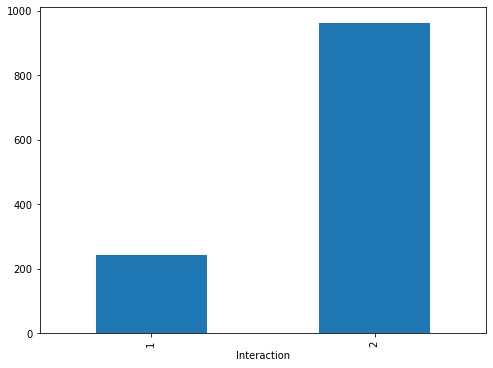

In [4]:
fig = plt.figure(figsize=(8,6))
df.groupby('Interaction').Review.count().plot.bar(ylim=0)
plt.show()

### Práca so STOPWORDS

In [5]:
# # odstránenie stopwords a pridanie výnimky pre slovo 'not'
# features = insAIProc.removeStopwordfromDataframeColumn(df,'not')
# # inicialiácia labels
# labels = df.Interaction



### Rozdelenie datasetu na training a test

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 0,test_size=0.20)

### Inicializácia modelu

In [7]:
# cv = CountVectorizer()
# rf = RandomForestClassifier(class_weight="balanced")
# # počet features na testovanie
# # arange definuje rozsah od 10000 do 50000 s postupnosťou po 5000
# n_features = np.arange(5000,50000,5000)

### Podporné funkcie

In [8]:
# # funkcia na výpočet skóre úspešnosti
# def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
#     sentiment_fit = pipeline.fit(X_train, y_train)
#     y_pred = sentiment_fit.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("accuracy score: {0:.2f}%".format(accuracy*100))
#     return accuracy

In [9]:
# # Testovacia funkcia s integrovanou pipeline
# def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
#     result = []
#     print(classifier)
#     print("\n")
#     for n in n_features:
#         vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
#         checker_pipeline = Pipeline([
#             ('vectorizer', vectorizer),
#             ('classifier', classifier)
#         ])
#         print("Test result for {} features".format(n))
#         nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
#         result.append((n,nfeature_accuracy))
#     return result

### Kontrola presnosti features

In [10]:
# tfidf2 = TfidfVectorizer()

# n_features = np.arange(100,1000,50)

# feature_result_tgt = insAIProc.nfeature_accuracy_checker( X_train, y_train, X_test, y_test, n_features, vectorizer=tfidf2,ngram_range=(1, 3))

### Klasifikačný report úspešnosti

In [11]:
# #Before we are done here, we should check the classification report.
# from sklearn.metrics import classification_report
# cv = CountVectorizer(max_features=15000,ngram_range=(1, 3))
# pipeline = Pipeline([
#         ('vectorizer', cv),
#         ('classifier', rf)
#     ])
# sentiment_fit = pipeline.fit(X_train, y_train)
# y_pred = sentiment_fit.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=['nelieci','lieci']))

### Chi-square aj vizualizácia v grafe

(1207, 2439)


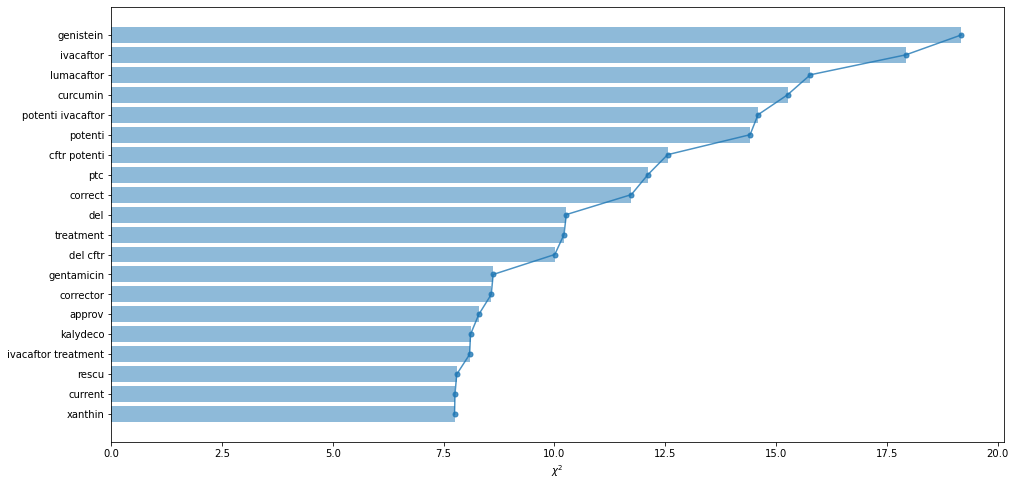

In [12]:
# odstránenie stopwords a pridanie výnimky pre slovo 'not'
features = insAIProc.removeStopwordfromDataframeColumn(df,'not')
# inicialiácia labels
labels = df.Interaction

tfidf = TfidfVectorizer(max_features=15000,sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

X_tfidf = tfidf.fit_transform(features).toarray()
y = labels
print(X_tfidf.shape)

chi2score = chi2(X_tfidf, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();